In [1]:
# loading required packages
!pip install tensorflow
!pip install tensorflow_datasets
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Flatten
from tensorflow.keras.metrics import Sum
import pandas as pd

You should consider upgrading via the 'c:\users\jkuhn\anaconda_new\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\jkuhn\anaconda_new\python.exe -m pip install --upgrade pip' command.


# Oxford Pet Dataset

In [2]:
# importing Oxford iii pet dataset
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

INFO[build.py]: Loading dataset oxford_iiit_pet:3.1.0 from imports: tensorflow_datasets.image_classification.oxford_iiit_pet


2021-11-18 22:15:50.402439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-18 22:15:50.402477: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-18 22:15:53.610596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-18 22:15:53.610664: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-18 22:15:53.619415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-RDF3FSH
2021-11-18 22:15:53.619522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-RDF3FSH
W1118 22:15:53.619584 36224 download_and_prepare.py:42] ***`tfds build` should be used instead of `downloa

In [3]:
print(info) # what is this dataset made of?

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\jkuhn\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [4]:
# extract an unseen dataset from test_dataset that will not be used in training
# we will take 10% of test dataset into an unseen dataset
dataset['unseen'] = dataset['test'].take(round(len(dataset['test'])*0.10))
dataset['test'] = dataset['test'].skip(round(len(dataset['test'])*0.10))
print('test size: ', len(dataset['test']))
print('unseen size: ', len(dataset['unseen']))

test size:  3302
unseen size:  367


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method = 'nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [6]:
train = dataset['train'].map(load_image_train)   # being able to open said images
test = dataset['test'].map(load_image_test)
unseen = dataset['unseen'].map(load_image_unseen)

In [7]:
BATCH_SIZE = 32    # spliting batch size for memory purposes
train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [8]:
def display(display_list, titles=[], display_string = None):
    plt.figure(figsize = (15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i==1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
        plt.show()
    
def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles = ['image', 'true mask'])

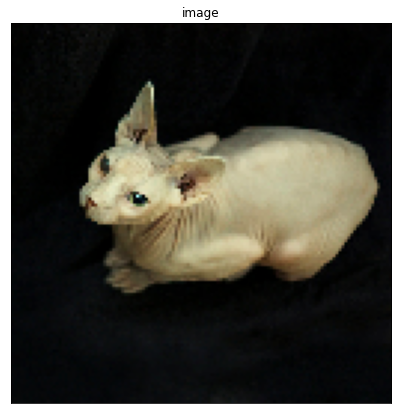

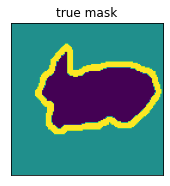

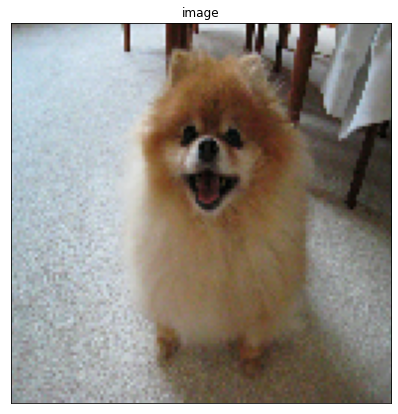

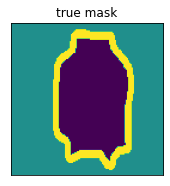

In [9]:
show_image_from_dataset(train)
show_image_from_dataset(test)

# ResNet101/Unet model

In [12]:
from keras.applications.resnet import ResNet101

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x = input_tensor
    for i in range(2):  # run the model twice
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

# creating resnet encoder
def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet.ResNet101(include_top = False, input_tensor = x, weights = None, input_shape = (128,128,3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# creating resnet decoder
def decoder_block(inputs, conv_output, n_filters, kernel_size, strides = 1, dropout = 0.3):
    u = tf.keras.layers.Conv2DTranspose(n_filters,kernel_size, strides = strides, padding = 'same')(inputs)  # bring the size back up for overview context
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)
    return c

def resnet_decoder_block(inputs, output_channels, model_name):
    conv_layers = []
    for layer in model_name.layers:
        name_layers = layer.name
        if name_layers.endswith('conv'):
            conv_layers.append(name_layers)  # get conv layer name from CNN
    
    model_inputs = []
    for name in conv_layers:  # get the layer information from said CNNs
        a = model_name.get_layer(name).output
        model_inputs.append(a)
    
    model_names = []  # get the outputs of each CNN blocks
    for m in range(len(model_inputs)):
        if model_inputs[m-1].shape[1] == model_inputs[m].shape[1]:
            continue
        model_names.append(model_inputs[m-1])
    model_names = model_names[1:] + model_names[:1]
    model_names = model_names[::-1]   # get the inverse for the decoder portion

    for conv in model_names[1:]: #[1:-1]:
        inputs = decoder_block(inputs, conv, n_filters = conv.shape[3], kernel_size = (3,3), strides = (2,2), dropout = 0.3)

        # transpose the results back to a (128, 128) image
        inputs = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3,3), strides = (16,16), kernel_initializer = 'he_normal', padding = 'same')(inputs)
        inputs = tf.keras.layers.Activation('relu')(inputs)
        # output a prediction
        inputs = tf.keras.layers.Conv2D(3, (1,1), activation = 'softmax')(inputs)
        return inputs

In [11]:
# creating the Resnet101- Unet model
OUTPUT_CHANNELS = 3

def ResNet101_Unet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3, ))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, output_channels = OUTPUT_CHANNELS, model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet101 = ResNet101_Unet()
model_unet_resnet101.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
# running the model
# callbacks are passed to the model via the callbacks argument in fit, which takes a list of callbacks. 
callbacks_list = [
    keras.callbacks.EarlyStopping(  # interrupts the training when improvement stops
        monitor = "accuracy",  # accuracy will provide the basis of the stopping
        patience = 3) # if it doesn't improve after 3 epochs
]

# run the model
EPOCHS = 10
model_unet_resnet101.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model_unet_resnet101_history = model_unet_resnet101.fit(train_dataset, epochs = EPOCHS, callbacks = callbacks_list, validation_data = test_dataset)

Epoch 1/10
115/115 [==============================] - 1285s 11s/step - loss: 1.0129 - accuracy: 0.5867 - val_loss: 0.9400 - val_accuracy: 0.5815
Epoch 2/10
115/115 [==============================] - 1216s 11s/step - loss: 0.9167 - accuracy: 0.5907 - val_loss: 0.9306 - val_accuracy: 0.5809
Epoch 3/10
115/115 [==============================] - 1267s 11s/step - loss: 0.9137 - accuracy: 0.5911 - val_loss: 0.9290 - val_accuracy: 0.5818
Epoch 4/10
115/115 [==============================] - 1301s 11s/step - loss: 0.9134 - accuracy: 0.5913 - val_loss: 0.9277 - val_accuracy: 0.5823
Epoch 5/10
115/115 [==============================] - 1309s 11s/step - loss: 0.9115 - accuracy: 0.5921 - val_loss: 0.9293 - val_accuracy: 0.5814
Epoch 6/10
115/115 [==============================] - 1287s 11s/step - loss: 0.9103 - accuracy: 0.5926 - val_loss: 0.9257 - val_accuracy: 0.5832
Epoch 7/10
115/115 [==============================] - 1289s 11s/step - loss: 0.9094 - accuracy: 0.5930 - val_loss: 0.9266 - val_ac

In [38]:
#model_unet_resnet101.save('unet_resnet101_model.h5')
model_unet_resnet101 = keras.models.load_model('unet_resnet101_model.h5')

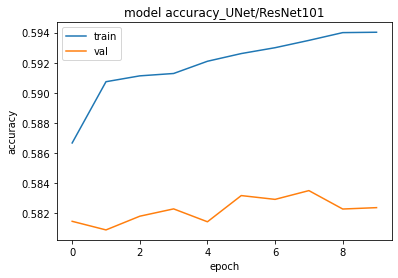

In [15]:
plt.plot(model_unet_resnet101_history.history['accuracy'])
plt.plot(model_unet_resnet101_history.history['val_accuracy'])
plt.title('model accuracy_UNet/ResNet101')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

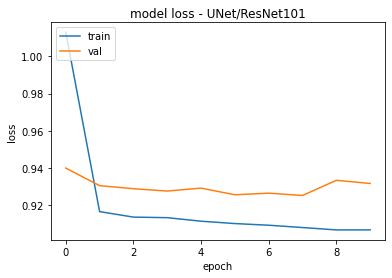

In [16]:
plt.plot(model_unet_resnet101_history.history['loss'])
plt.plot(model_unet_resnet101_history.history['val_loss'])
plt.title('model loss - UNet/ResNet101')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [17]:
integer_slides = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()

def make_predictions(image, mask, num=1):
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model_unet_resnet101.predict(image)
    pred_mask = create_mask(pred_mask)
    return pred_mask

def get_image_and_annotation_arrays(dataset):
    ds = dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)

    images = []
    y_true_segments = []

    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples) - (info.splits['test'].num_examples %BATCH_SIZE)]
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples %BATCH_SIZE))], y_true_segments

def iou_score(target, pred):
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection)/np.sum(union)
    return iou_score

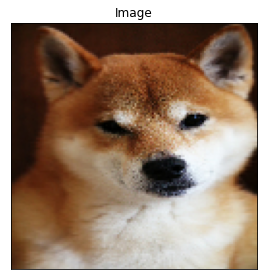

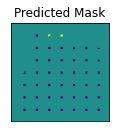

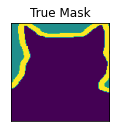

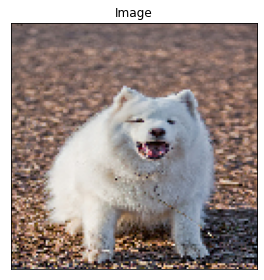

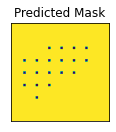

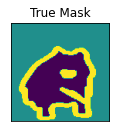

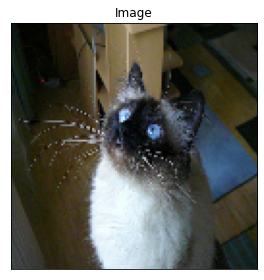

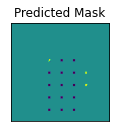

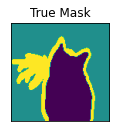

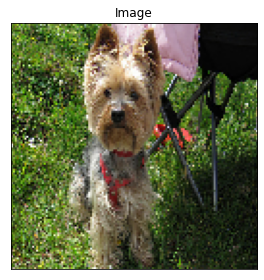

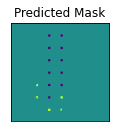

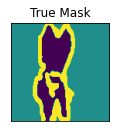

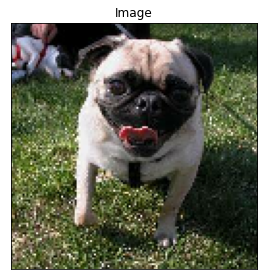

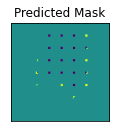

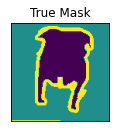

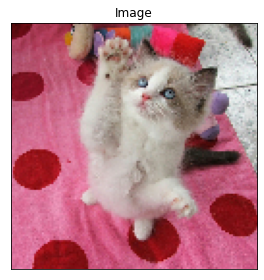

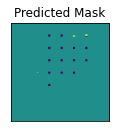

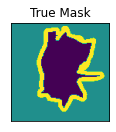

In [27]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ['Image', 'Predicted Mask', 'True Mask'])

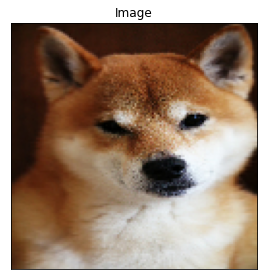

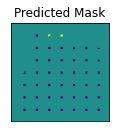

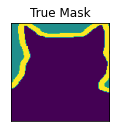

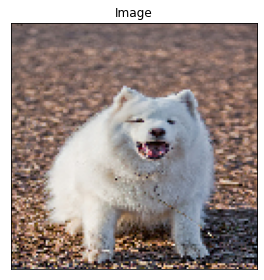

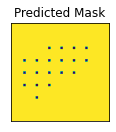

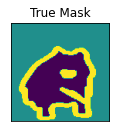

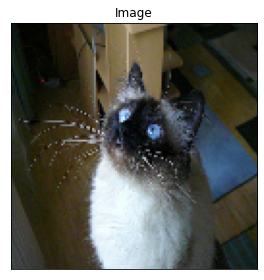

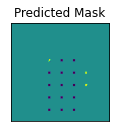

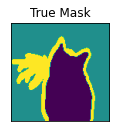

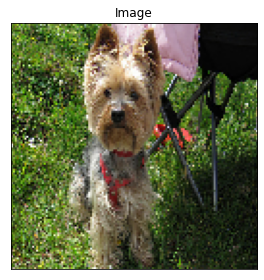

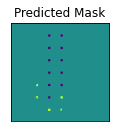

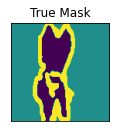

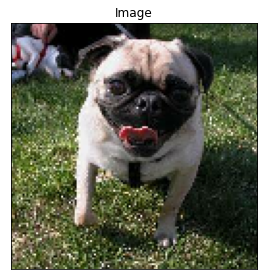

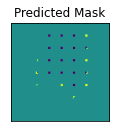

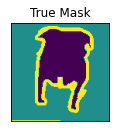

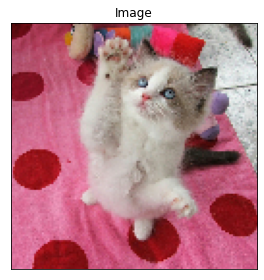

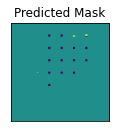

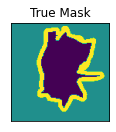

In [28]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet101.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ["Image", "Predicted Mask", "True Mask"])

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [40]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet101.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.7014987083760688
test IoU:  0.7015996496325325
unseen IoU:  0.6986563769004821


# U-Net/ResNet101 with imagenet pre-trained weights

In [51]:
# creating resnet encoder
def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet.ResNet101(include_top = False, input_tensor = x, weights = 'imagenet', input_shape = (128,128,3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# creating the Resnet101- Unet model
OUTPUT_CHANNELS = 3

def ResNet101_Unet_imagenet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3, ))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, output_channels = OUTPUT_CHANNELS, model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet101_imagenet = ResNet101_Unet_imagenet()
model_unet_resnet101_imagenet.summary()

171458560/171446536 [==============================] - 39s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
________________________

In [52]:
# running the model
# callbacks are passed to the model via the callbacks argument in fit, which takes a list of callbacks. 
callbacks_list = [
    keras.callbacks.EarlyStopping(  # interrupts the training when improvement stops
        monitor = "accuracy",  # accuracy will provide the basis of the stopping
        patience = 3) # if it doesn't improve after 3 epochs
]

# run the model
EPOCHS = 10
model_unet_resnet101_imagenet.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model_unet_resnet101_imagenet_history = model_unet_resnet101_imagenet.fit(train_dataset, epochs = EPOCHS, callbacks = callbacks_list, validation_data = test_dataset)

Epoch 1/10
115/115 [==============================] - 1299s 11s/step - loss: 0.9936 - accuracy: 0.5893 - val_loss: 0.9669 - val_accuracy: 0.5774
Epoch 2/10
115/115 [==============================] - 1274s 11s/step - loss: 0.9025 - accuracy: 0.5961 - val_loss: 0.9673 - val_accuracy: 0.5774
Epoch 3/10
115/115 [==============================] - 1244s 11s/step - loss: 0.8991 - accuracy: 0.5971 - val_loss: 0.9596 - val_accuracy: 0.5774
Epoch 4/10
115/115 [==============================] - 1303s 11s/step - loss: 0.8982 - accuracy: 0.5974 - val_loss: 0.9645 - val_accuracy: 0.5774
Epoch 5/10
115/115 [==============================] - 1395s 12s/step - loss: 0.8976 - accuracy: 0.5976 - val_loss: 0.9495 - val_accuracy: 0.5785
Epoch 6/10
115/115 [==============================] - 1332s 12s/step - loss: 0.8964 - accuracy: 0.5981 - val_loss: 0.9291 - val_accuracy: 0.5841
Epoch 7/10
115/115 [==============================] - 1291s 11s/step - loss: 0.8956 - accuracy: 0.5984 - val_loss: 0.9202 - val_ac

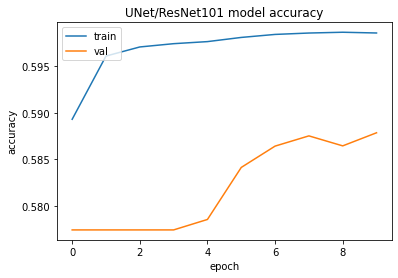

In [53]:
plt.plot(model_unet_resnet101_imagenet_history.history['accuracy'])
plt.plot(model_unet_resnet101_imagenet_history.history['val_accuracy'])
plt.title('UNet/ResNet101 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

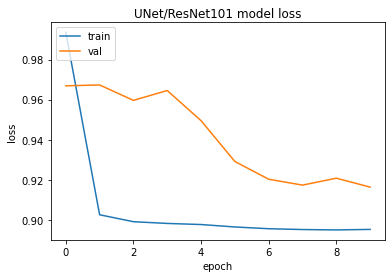

In [54]:
plt.plot(model_unet_resnet101_imagenet_history.history['loss'])
plt.plot(model_unet_resnet101_imagenet_history.history['val_loss'])
plt.title('UNet/ResNet101 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [56]:
model_unet_resnet101_imagenet.save('unet_resnet101_imagenet_model.h5')
model_unet_resnet101_imagenet = keras.models.load_model('unet_resnet101_imagenet_model.h5')

In [19]:
integer_slides = round(len(dataset['test'])*0.10)

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()

def make_predictions(image, mask, num=1):
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model_unet_resnet101_imagenet.predict(image)
    pred_mask = create_mask(pred_mask)
    return pred_mask

def get_image_and_annotation_arrays(dataset):
    ds = dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)

    images = []
    y_true_segments = []

    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples) - (info.splits['test'].num_examples %BATCH_SIZE)]
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples %BATCH_SIZE))], y_true_segments

def iou_score(target, pred):
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection)/np.sum(union)
    return iou_score

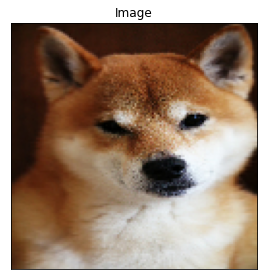

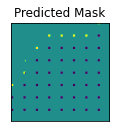

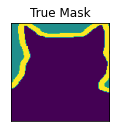

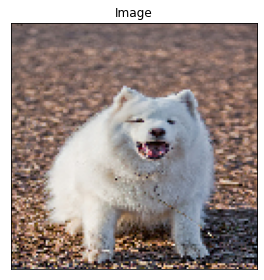

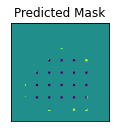

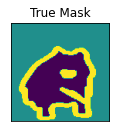

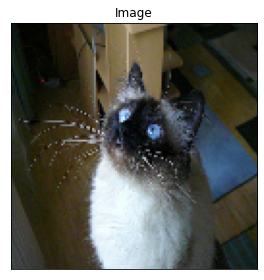

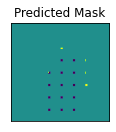

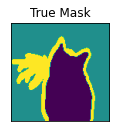

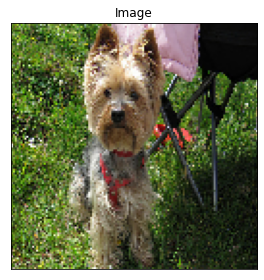

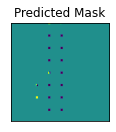

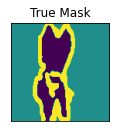

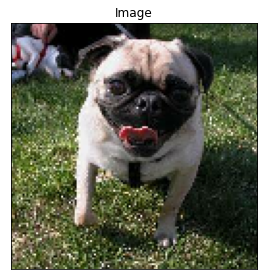

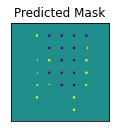

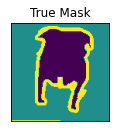

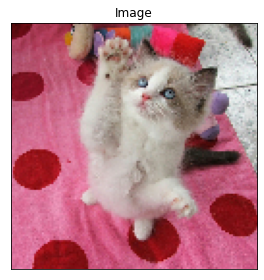

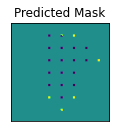

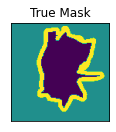

In [58]:
image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ['Image', 'Predicted Mask', 'True Mask'])

In [60]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet101_imagenet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.706209249810797
test IoU:  0.7056003225987553
unseen IoU:  0.7026440664084541


# U-Net/REsNet101 with data augmentation

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def random_flip(input_image, input_mask):   # flips images and adds brightness differences
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_unseen(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')
    
    # adding a horizontal and vertical shift, adjust the brightness
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [10]:
train = dataset['train'].map(load_image_train)
unseen = dataset['unseen'].map(load_image_unseen)
test = dataset['test'].map(load_image_test)

BATCH_SIZE = 32

train_dataset = train.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)
unseen_dataset = unseen.batch(BATCH_SIZE)

In [13]:
# creating resnet encoder
def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet.ResNet101(include_top = False, input_tensor = x, weights = None, input_shape = (128,128,3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# creating the Resnet101- Unet model
OUTPUT_CHANNELS = 3

def ResNet101_Unet_augmentation():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3, ))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, output_channels = OUTPUT_CHANNELS, model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet101_augmentation = ResNet101_Unet_augmentation()
model_unet_resnet101_augmentation.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
# running the model
# callbacks are passed to the model via the callbacks argument in fit, which takes a list of callbacks. 
callbacks_list = [
    keras.callbacks.EarlyStopping(  # interrupts the training when improvement stops
        monitor = "accuracy",  # accuracy will provide the basis of the stopping
        patience = 3) # if it doesn't improve after 3 epochs
]

# run the model
EPOCHS = 10
model_unet_resnet101_augmentation.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model_unet_resnet101_augmentation_history = model_unet_resnet101_augmentation.fit(train_dataset, epochs = EPOCHS, callbacks = callbacks_list, validation_data = test_dataset)

Epoch 1/10
115/115 [==============================] - 1227s 11s/step - loss: 1.0339 - accuracy: 0.5864 - val_loss: 0.9560 - val_accuracy: 0.5814
Epoch 2/10
115/115 [==============================] - 1194s 10s/step - loss: 0.9240 - accuracy: 0.5906 - val_loss: 0.9298 - val_accuracy: 0.5813
Epoch 3/10
115/115 [==============================] - 1194s 10s/step - loss: 0.9140 - accuracy: 0.5910 - val_loss: 0.9301 - val_accuracy: 0.5810
Epoch 4/10
115/115 [==============================] - 1192s 10s/step - loss: 0.9128 - accuracy: 0.5915 - val_loss: 0.9295 - val_accuracy: 0.5813
Epoch 5/10
115/115 [==============================] - 1192s 10s/step - loss: 0.9117 - accuracy: 0.5920 - val_loss: 0.9828 - val_accuracy: 0.5794
Epoch 6/10
115/115 [==============================] - 1193s 10s/step - loss: 0.9103 - accuracy: 0.5926 - val_loss: 0.9294 - val_accuracy: 0.5812
Epoch 7/10
115/115 [==============================] - 1192s 10s/step - loss: 0.9091 - accuracy: 0.5931 - val_loss: 0.9245 - val_ac

In [15]:
model_unet_resnet101_augmentation.save('unet_resnet101_augmented_model.h5')
model_unet_resnet101_augmentation = keras.models.load_model('unet_resnet101_augmented_model.h5')

C:\Users\jkuhn\anaconda_new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


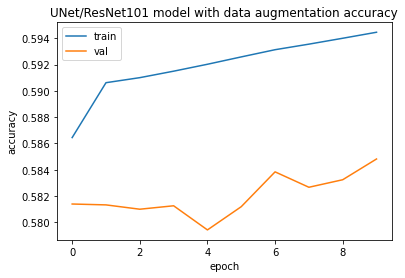

In [16]:
plt.plot(model_unet_resnet101_augmentation_history.history['accuracy'])
plt.plot(model_unet_resnet101_augmentation_history.history['val_accuracy'])
plt.title('UNet/ResNet101 model with data augmentation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

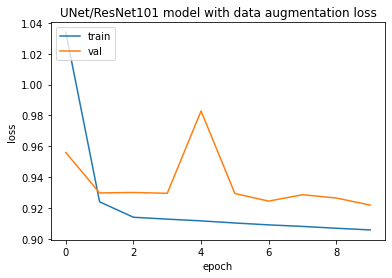

In [17]:
plt.plot(model_unet_resnet101_augmentation_history.history['loss'])
plt.plot(model_unet_resnet101_augmentation_history.history['val_loss'])
plt.title('UNet/ResNet101 model with data augmentation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

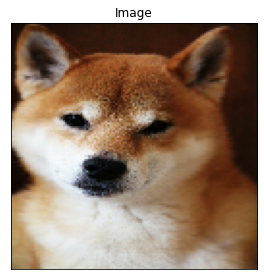

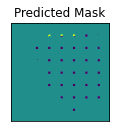

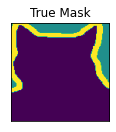

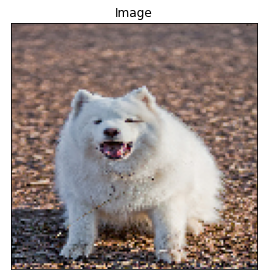

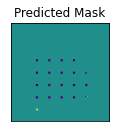

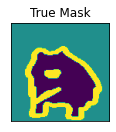

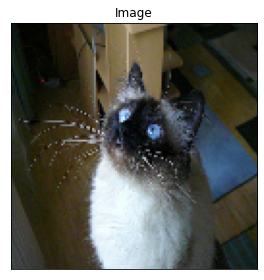

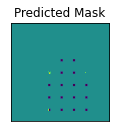

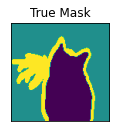

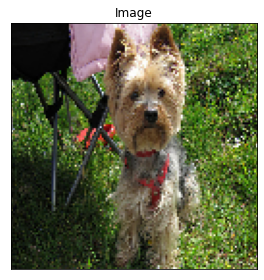

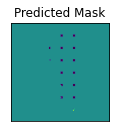

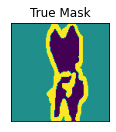

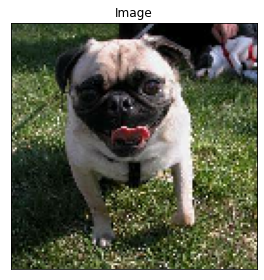

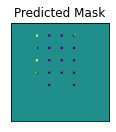

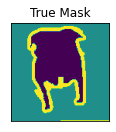

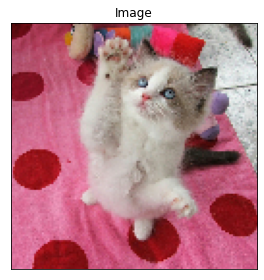

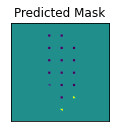

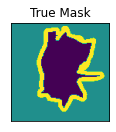

In [20]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet101_augmentation.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ['Image', 'Predicted Mask', 'True Mask'])

In [21]:
# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.7036186535973862
test IoU:  0.7037201322006428
unseen IoU:  0.7005666263769608


# U-Net/ResNet101 with imagenet pre-trained weights and data augmentation

In [22]:
# creating resnet encoder
def resnet_block(input_tensor):
    x = input_tensor
    base_model = tf.keras.applications.resnet.ResNet101(include_top = False, input_tensor = x, weights = 'imagenet', input_shape = (128,128,3))
    x = base_model.output
    modeling = tf.keras.Model(inputs = input_tensor, outputs = x)
    return x, modeling

# creating the Resnet101- Unet model
OUTPUT_CHANNELS = 3

def ResNet101_Unet_augmentation_imagenet():
    inputs = tf.keras.layers.Input(shape = (128, 128, 3, ))
    encoder_output, model_name = resnet_block(inputs)
    outputs = resnet_decoder_block(encoder_output, output_channels = OUTPUT_CHANNELS, model_name = model_name)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model

model_unet_resnet101_augmentation_imagenet = ResNet101_Unet_augmentation_imagenet()
model_unet_resnet101_augmentation_imagenet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [23]:
# running the model
# callbacks are passed to the model via the callbacks argument in fit, which takes a list of callbacks. 
callbacks_list = [
    keras.callbacks.EarlyStopping(  # interrupts the training when improvement stops
        monitor = "accuracy",  # accuracy will provide the basis of the stopping
        patience = 3) # if it doesn't improve after 3 epochs
]

# run the model
EPOCHS = 10
model_unet_resnet101_augmentation_imagenet.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model_unet_resnet101_augmentation_imagenet_history = model_unet_resnet101_augmentation_imagenet.fit(train_dataset, epochs = EPOCHS, callbacks = callbacks_list, validation_data = test_dataset)

Epoch 1/10
115/115 [==============================] - 1212s 10s/step - loss: 0.9975 - accuracy: 0.5897 - val_loss: 0.9953 - val_accuracy: 0.5793
Epoch 2/10
115/115 [==============================] - 1207s 11s/step - loss: 0.9053 - accuracy: 0.5956 - val_loss: 1.0291 - val_accuracy: 0.5774
Epoch 3/10
115/115 [==============================] - 1204s 10s/step - loss: 0.9006 - accuracy: 0.5965 - val_loss: 0.9773 - val_accuracy: 0.5774
Epoch 4/10
115/115 [==============================] - 1203s 10s/step - loss: 0.8994 - accuracy: 0.5970 - val_loss: 0.9799 - val_accuracy: 0.5774
Epoch 5/10
115/115 [==============================] - 1244s 11s/step - loss: 0.8986 - accuracy: 0.5973 - val_loss: 0.9423 - val_accuracy: 0.5799
Epoch 6/10
115/115 [==============================] - 1263s 11s/step - loss: 0.8982 - accuracy: 0.5975 - val_loss: 0.9584 - val_accuracy: 0.5784
Epoch 7/10
115/115 [==============================] - 1334s 12s/step - loss: 0.8976 - accuracy: 0.5977 - val_loss: 0.9357 - val_ac

In [24]:
model_unet_resnet101_augmentation_imagenet.save('unet_resnet101_augmented_imagenet_model.h5')
model_unet_resnet101_augmentation_imagenet = keras.models.load_model('unet_resnet101_augmented_imagenet_model.h5')

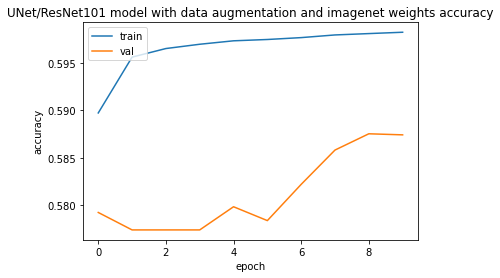

In [25]:
plt.plot(model_unet_resnet101_augmentation_imagenet_history.history['accuracy'])
plt.plot(model_unet_resnet101_augmentation_imagenet_history.history['val_accuracy'])
plt.title('UNet/ResNet101 model with data augmentation and imagenet weights accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

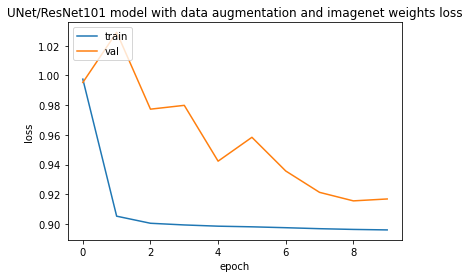

In [26]:
plt.plot(model_unet_resnet101_augmentation_imagenet_history.history['loss'])
plt.plot(model_unet_resnet101_augmentation_imagenet_history.history['val_loss'])
plt.title('UNet/ResNet101 model with data augmentation and imagenet weights loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

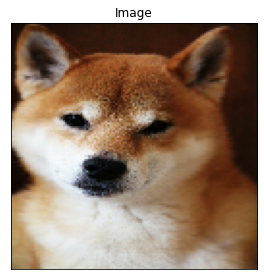

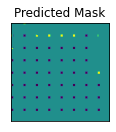

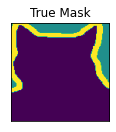

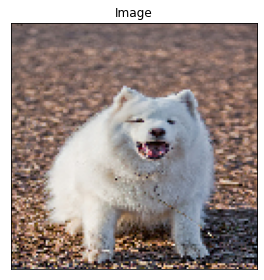

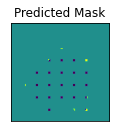

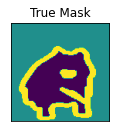

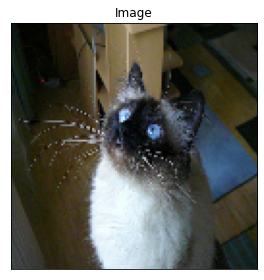

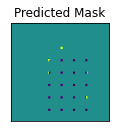

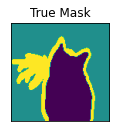

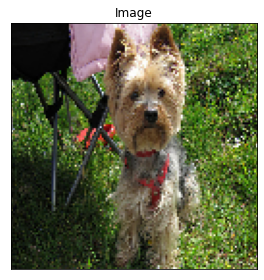

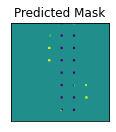

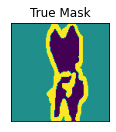

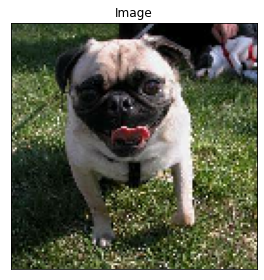

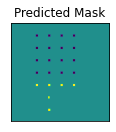

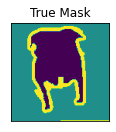

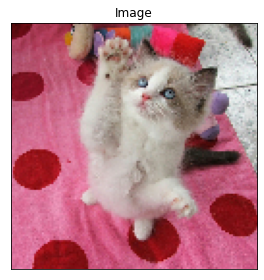

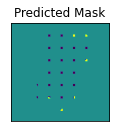

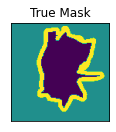

In [27]:
def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model_unet_resnet101_augmentation_imagenet.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

image_num = [15, 28, 32, 50, 72, 80]

for i in image_num:
    y_true_images, y_true_segments = get_image_and_annotation_arrays(unseen_dataset)
    y_pred_mask = make_predictions(y_true_images[i], y_true_segments[i])
    display([y_true_images[i], y_pred_mask, y_true_segments[i]], ['Image', 'Predicted Mask', 'True Mask'])

In [28]:
# train IoU
predictions_train = []
train_image, train_mask = get_image_and_annotation_arrays(train_dataset)
for i in range(len(train_image)):
    y_pred_mask = make_predictions(train_image[i], train_mask[i])
    predictions_train.append(y_pred_mask)
print('train IoU: ', iou_score(train_mask, predictions_train))

# test IoU
predictions_test = []
test_image, test_mask = get_image_and_annotation_arrays(test_dataset)
for i in range(len(test_image)):
    y_pred_mask = make_predictions(test_image[i], test_mask[i])
    predictions_test.append(y_pred_mask)
print('test IoU: ', iou_score(test_mask, predictions_test))

# unseen IoU
predictions_unseen = []
unseen_image, unseen_mask = get_image_and_annotation_arrays(unseen_dataset)
for i in range(len(unseen_image)):
    y_pred_mask = make_predictions(unseen_image[i], unseen_mask[i])
    predictions_unseen.append(y_pred_mask)
print('unseen IoU: ', iou_score(unseen_mask, predictions_unseen))

train IoU:  0.705058933481686
test IoU:  0.7048002482402704
unseen IoU:  0.7018607798785229
